# NSMC로 감정 분석(텍스트 분류) 하기

![image](https://user-images.githubusercontent.com/74717033/136889399-acb7afa3-47e7-4246-b61f-2609fffead3c.png)

> Reference : https://www.kdnuggets.com/2018/03/5-things-sentiment-analysis-classification.html

## 감정분석이란?

* Natural Language Processing, Text Analysis, Computational Lingustics, biometrics 같은 방법을 이용해 텍스트에 숨겨져있는 저자의 의도나 정보를 찾아내는 모든 방법


* 별칭 : Opinion Mining, Sentiment Mining, Subjectivity Analysis 


* 초반의 방법들은 텍스트의 극성(Polarity)를 찾기 위해 많이 시도되었다. 대표적인 예로 <b>긍정/부정</b>으로 나누는 케이스가 있다.


* 감정 분석은 크게 Knowledge-based approach, Machine Learning-based approach가 있다.

> Knowledge-based는 기존에 human expert가 알려진 어구, 어미, 관용 표현등을 활용하여 문서들에 대해 평가한 데이터를 가져와 평가하는 방법.

> 당시에는 데이터를 대규모로 모으고, 기존 base로 판단할 수 있게 정제하는 것이 중요했다.
> 하지만 이는 데이터의 급증, 다양하고 새로운 개념의 급증 등으로 인해 Knowledge-based 분석에 한계점에 도달 -> ML-based approach 로 발전하였다.
---
> ML-based approach는 supervised, unsupervised 방법이 있다. 최근 pretrained Language Model이 비약적으로 발달함에 따라 unsupervised 방법의 성능도 많이 높아졌지만, 아직까지는 성능면에선 supervised가 월등히 높다.

* unsupervised가 어려운 이유는 감정이 문화권의 영향을 많이 받기 때문이다. 
    * 같은 단어/표현도 문화권에 따라 의미가 달라 질 수 있다.
    * 한국의 "밥 한번 먹자!" 와 영미권의 "밥 한번 먹자!" 는 의미가 다를 수 있다.
* 그래서 단어에 대한 label을 가진채로 학습을 시키는 supervised의 성능이 더 높을 수 밖에 없다.



* 여기서는 가장 많이 쓰이는 방법인 text classification으로서의 sentiment analysis를 정리한다.

## 텍스트 분류 (Text Classification)

* **벡터 형태**로 표현된 텍스트를 말그대로 분류하는 방법.(일반적으로 supervised)
    - 텍스트가 node


* DNN이 비약적으로 성능 향상을 가져오기 전까지는 SVM이 가장 많이 사용되었다.
    

* 현재는 CNN, LSTM을 분류 모델로 가장 많이 사용한다.


* 실제로 텍스트 분류 작업은 큰 범위에서 대부분의 NLP downstream task를 포함한다.
    * 하나의 예로, Siamese Network(Bi-LSTM model)라는 걸 통해서 Question-Answering pair를 학습하게 되면, 분류의 기준이 "특정 질문에 맞는 정답을 잘 골랐는가 아닌가(0 / 1)"를 해결하는 문제로 바뀌게 된다.

# scikit-learn으로 NSMC 감정분석 하기

## 데이터 불러오기(NSMC 데이터)

In [1]:
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
    return documents
    
train_docs = read_documents("ratings_train.txt")
test_docs = read_documents("ratings_test.txt")

In [2]:
print(len(train_docs))
print(len(test_docs))

150000
50000


## MeCab 함수설정

In [4]:
"""
    Parsing 규칙의 문제점, split을 "," 기준으로 하는데, token이 "," 인 경우에는 쉼표만 잘려서 나오기 때문에, 
    + "%," 같이 특수문자와 쉼표가 같이 등장하는 경우도 생각해주어야 함.
    
    (",", "SC") 의 원래 튜플이 만들어지지 않음.
    
    명사 분석의 경우 해당 토큰이 필요하지 않으니 pass
    
    형태소 분석과 POS tagging의 경우 해당 토큰이 필요하므로, token[0]이 ' 인 경우엔 따로 (",", "SC")를 집어 넣어줘야함.
"""
import MeCab # 윈도우 명령어
import re

mecab = MeCab.Tagger()

def mecab_nouns(text):
    nouns = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    # 추출한 token중에 POS가 명사 분류에 속하는 토큰만 선택.
    for token in temp:
        if token[1] == "NNG" or token[1] == "NNP" or token[1] == "NNB" or token[1] == "NNBC" or token[1] == "NP" or token[1] == "NR":
            nouns.append(token[0])
        
    return nouns

def mecab_morphs(text):
    morphs = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    # 추출한 token중에 문자열만 선택.
    for token in temp:
        morphs.append(token[0])
    
    return morphs

def mecab_pos(text):
    pos = []
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    pos = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    return pos

## 텍스트 클리닝 함수

In [5]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
        
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab_morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab_nouns(doc) if word not in SW and len(word) > 1]

## 품사 태그를 붙여서 토크나이징 + 클리닝

In [8]:
from konlpy.tag import Mecab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

#okt = Okt()
mecab = MeCab.Tagger()

SW = define_stopwords("stopwords-ko.txt")

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    """
    2가지 버전 
    # if text_tokenizing(line[1])을 하는 이유 (명사 추출시에 유용)
    # '...', 'ㅋㅋㅋ' 등은 명사추출하면 out됨 -> 빈 list 
    # 빈 list가 있으면 벡터화 할때 에러 날 수 있음
    """
    # text cleaning 한 버전
    # cleaning을 해도 ... / ㅋㅋㅋ 등으로 생기는 공백은 마찬가지
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(text_cleaning(line[1]))]
    # text cleaning 하지 않은 버전
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(line[1])]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['GDNTOPCLASSINTHECLUB'], '0']


In [12]:
# 정제 후 빠진 데이터의 수 파악
print( len(train_docs) - len(train_data))
print(len(test_docs) - len(test_data) )

1949
641


In [13]:
print(train_data[:3])

[[['진짜', '짜증', '네요', '목소리'], '0'], [['..', '포스터', '보고', '초딩', '영화', '...', '오버', '연기', '조차', '가볍', '구나'], '1'], [['너무', '밓었다그래서보는것을추천한다'], '0']]


* 데이터 분석을 하기 위해 기본적인 정보들을 확인

* nltk 라이브러리를 이용하여 전처리

## 결과 시각화(histogram)

In [14]:
import nltk

total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

1206841


In [15]:
text = nltk.Text(total_tokens, name='NMSC')
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

51722
[('영화', 57614),
 ('..', 22813),
 ('는데', 11543),
 ('너무', 11002),
 ('정말', 9783),
 ('으로', 9322),
 ('네요', 9053),
 ('재밌', 9022),
 ('지만', 8366),
 ('진짜', 8326)]


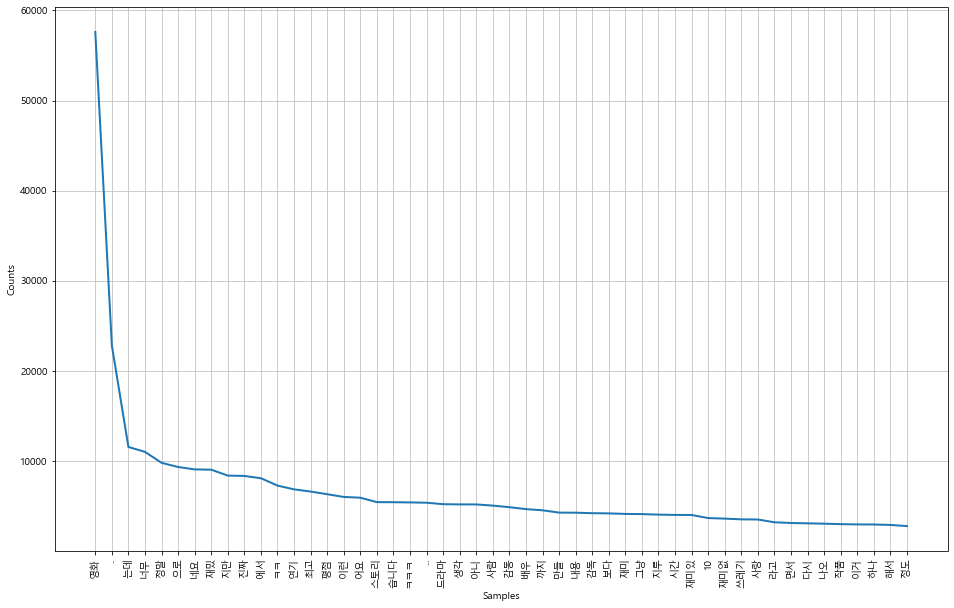

In [16]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system..')

plt.figure(figsize=(16, 10))
text.plot(50)

- 사실, 형태소 분석을 한결과를 histogram으로만 봐서는 큰 의미를 찾기 어렵다.

In [17]:
# 여러 리스트들을 하나로 묶어 주는 함수
# sklearn의 CountVectorizer함수는 input이 무조건 str이다.
# 함수에 입력하면서 옵션을 줘도 되지만 미리 변경해두면 더욱 편하다.

def list_to_str(List): 
    return " ".join(List)

# Linear Classifier와 Support Vector Machine으로 nsmc 분류하기

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# list 묶는 함수 적용해서 train & test split
train_x = [list_to_str(doc) for doc, _ in train_data]
test_x = [list_to_str(doc) for doc, _ in test_data]
train_y = [label for _, label in train_data]
test_y = [label for _, label in test_data]

#print(len(train_x), len(train_y))
print("For %d train data" % len(train_x))
#print(len(test_x), len(test_y))

# 각 모델별 pipeline 구축

"""
loss = perceptron : 1차원 linear classifier
성능 향상은 penalty , alpha, max_iter 조정하여 가능하다.
CountVectorizer() 에 아래와 같은 옵션으로 넣어 볼 수 있다.
1) max_features (상위 몇개만 모델에 돌릴건지) 
2) min_df (전체 문서에서 지정한 횟수 이하로 등장하는 단어 drop)
clf : classifier
"""


# 1. Perceptron linear classifier
learner = Pipeline([
    ('vect', CountVectorizer()), # 벡터화방법 설정
    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=100)) # classifier 설정
])

"""
노이즈가 심하거나 선형으로 분류하기 어려운 데이터를
SVM의 kernel로 데이터를 가져와 공간변화를 하면 선형분류가 되는
공간으로 오게되어 선형분류를 가능하게 한다.
문제는 '어떤 커널이 가장 성능이 좋은가?' 를 알 수가 없다는 것이다.
더욱이 텍스트 데이터는 벡터화가 되면서 고차원이 되기때문에 데이터 구조를
알 수가 없어 더더욱 파악이 어렵다. 
PCA등으로 대략적으로 알수는 있지만, 실제 데이터간의 분포를 정확하게 아는 것은 무리이다.
결국 모든 커널에서 직접 분석을 해봐야 알 수 있다.
"""

# 2. SVM with linear kernel
learner2 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='linear'))
    
])

# 3. SVM with polynomial kernel
# 몇 차원짜리 polynomial를 쓸 것인지 degree를 정해줘야 한다.
# degree가 높을 수록 오래걸리는 대신 좀 더 많은 구분이 가능하다.
learner3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='poly', degree=8))
])

# 4. SVM with Radius Basis Function kernel
# SVM에서 가장 많이 쓰이는 kernel
learner4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='rbf'))
])

# 5. SVM with sigmoid kernel
learner5 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='sigmoid'))
])

# 6. Navie Bayes Classifier (Multinomial Ver.)
# feature간에 상호 독립성이 유지가 된다는 전제하에
# 의외로 강력한 성능을 자랑한다.
learner6 = Pipeline([
    ('vect', CountVectorizer()),
    ('mb', MultinomialNB())
])

# 학습기 선정
#classifier = learner # Perceptron linear classifier
classifier = learner2 # SVM with linear kernel
#classifier = learner3 # SVM with polynomial
#classifier = learner4 # SVM with Radius Basis Function
#classifier = learner5 # SVM with sigmoid
#classifier = learner6 # Navie Bayes Classifier (Multinomial Ver)


classifier.fit(train_x, train_y) # 데이터 입력

# train
train_predict = classifier.predict(train_x) # 예측
# 원래는 validation한 뒤에 평가하는게 맞음
train_accuracy = np.mean(train_predict == train_y) # 정확도 평가

# test
test_predict = classifier.predict(test_x)
test_accuracy = np.mean(test_predict == test_y)

# 결과 확인 
print("For %d test data" % len(test_x)) 
print("Training Accuracy : %.2f" % train_accuracy)
print("Test Accuracy : %.2f" % test_accuracy)

For 148051 train data


In [20]:
lenner = {'num_of train data': 148051, 'num_of test data' :49359, 'Trainin Accuracy':0.84, 'Test Accuracy':
0.77}
lenner2 = {'num_of train data': 148051, 'num_of test data' :49359, 'Trainin Accuracy':0.84, 'Test Accuracy':
0.77}

### < 실험결과 >

#### Linear Classifier 학습하여, test accuracy를 측정. (learner)

1. 명사만 추출 : 0.51
2. 전처리 하지 않고 형태소 분석 : 0.67
3. 전처리 하고 형태소 분석 : 0.71

-----여기까진 top 500 features만 사용(CountVectorizer(max_features=500))-----

4. 3 + 모든 feature : 0.76

### < 실험결과 >

#### SVM Classifier 학습하여, test accuracy를 측정. (learner2)

1. 명사만 추출 : 0.53
2. 전처리 하지 않고 형태소 분석 : 0.72
3. 전처리 하고 형태소 분석 : 0.77

-----여기까진 top 500 features만 사용--------

4. 3 + 모든 feature : 0.81

# 결론
---
- 1) 일반적으로 '명사'만 추출했을때는 SVM을 해도 분류문제에서 큰 정보를 주지 못한다.
    - accuracy가 0.51인데, 0.5에 가깝다는 것은 binary clf 인데 거의 찍는 수준
- '('나  ','등의 특수문자등이 제거된 경우 성능이 더 올라갈 수 있다.
    - 토큰을 조금 더 단일화 (text normalization) 해주었기 때문
- 상위 500개등 소수의 데이터를 쓰는 것보다 전체 데이터를 쓰는 것이 더 높은 성능을 이끌어 낼 수 있다.

# 추가 실험
---

1. CountVectorizer와 TF-IDF Vectorizer 중 어떤 것이 더 성능이 좋을지 비교해보기
2. CountVectorizer에서 max_feature, min_df, max_df 등 feature selection하는 방법들이 있는데, 어떤 방식을 했을때 가장 성능이 좋을까?
3. SVM에서 최적의 하이퍼 파라미터 튜닝은 어떤 것일까?